# Connect to OPeNDAP
Here is a tutorial on how to use OPeNDAP to get at data on the THREDDS server at NKN (Univeristy of Idaho): https://climate.northwestknowledge.net/MACA/OPENDAP.php

There are a couple of places on the THREDDS server where there are drought indicators: 
-	[CIRC Drought folder](http://thredds.northwestknowledge.net:8080/thredds/catalog/DROUGHT_LAYERS/catalog.html): VEGDRI, USDM, QUICKDRI, MCDI, LERI, GRADE, FDSI, ESI
-	[GRIDMET DROUGHT indicators](http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_MET_aggregated_catalog.html): SPI/SPEI/EDDI at different timescales (these are in the Drought Stripes tool)
-	VIC DROUGHT indicators: I'm currently making these from the WUSA/CONUS datasets for SRI (standardized runoff index), SM/TM/SWE percentiles
    -	[WUSA](http://thredds.northwestknowledge.net:8080/thredds/catalog/VIC_UCLA/VIC-WUSA/catalog.html)-  there's going to be some new files soon that all the daily data in a single file
    -	[CONUS](http://thredds.northwestknowledge.net:8080/thredds/catalog/VIC_UCLA/VIC-CONUS/catalog.html) - there's going to be some new files soon that all the daily data in a single file

There's also another resource you should be aware of that might help:    
-	[Climate Engine](https://app.climateengine.com/climateEngine)    
    -	USDM raster data over CONUS: there is a rasterized version of the USDM drought classification over CONUS that might be useful to pull a time series from for a point location. I'm looking to put this full raster data on THREDDS at some point soon.. just need some time to aggregate the files. 
    -	Standardized NDVI or  percentiles in NDVI from remote sensing (MODIS or Landsat) might be useful here for vegetation drought.


In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
from netCDF4 import Dataset
from tqdm.autonotebook import tqdm

dirPath = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
cwd = '/pool0/home/steinadi/data/drought/drought_impact/Data'

Populating the interactive namespace from numpy and matplotlib


<ipython-input-1-7c521906f6fd>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
file = 'DROUGHT_LAYERS/VEGDRI/vegdri_20201011.nc'
sample = xr.open_dataset(f"{dirPath}/{file}")
sample

<xarray.Dataset>
Dimensions:  (lat: 2687, lon: 5791)
Coordinates:
  * lat      (lat) float64 51.77 51.75 51.74 51.73 ... 22.51 22.5 22.49 22.48
  * lon      (lon) float64 -128.5 -128.5 -128.5 -128.5 ... -65.42 -65.41 -65.4
Data variables:
    vegdri   (lat, lon) float64 ...

Awesome, so we have access. We unfortunately can't do `open_mfdataset` and us a wildcard, so will have to get a bit more creative ...

## VEGDRI

In [16]:
sample['vegdri']

<xarray.DataArray 'vegdri' (lat: 2687, lon: 5791)>
[15560417 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 51.77 51.75 51.74 51.73 ... 22.51 22.5 22.49 22.48
  * lon      (lon) float64 -128.5 -128.5 -128.5 -128.5 ... -65.42 -65.41 -65.4
Attributes:
    description:    VegDRI data provided by USGS as their web site https://ed...
    long_name:      vegdri
    standard_name:  vegdri
    units:          %
    _ChunkSizes:    [448 966]

In [3]:
# looks like VEGDRI is weekly from 2019-03-10 to 2020-10-11
vegdri_dates = pd.date_range('2019-03-10','2020-10-11', freq='W')#.strftime("%Y%m%d")

vegdri = xr.Dataset(
    coords = dict(
        lat = sample['lat'].values,
        lon = sample['lon'].values,
        time = vegdri_dates
    ),
    data_vars = dict(
        vegdri=(['lat','lon','time'], np.empty((len(sample['lat'].values), len(sample['lon'].values), len(vegdri_dates))) * np.nan)
    )
)
vegdri

<xarray.Dataset>
Dimensions:  (lat: 2687, lon: 5791, time: 84)
Coordinates:
  * lat      (lat) float64 51.77 51.75 51.74 51.73 ... 22.51 22.5 22.49 22.48
  * lon      (lon) float64 -128.5 -128.5 -128.5 -128.5 ... -65.42 -65.41 -65.4
  * time     (time) datetime64[ns] 2019-03-10 2019-03-17 ... 2020-10-11
Data variables:
    vegdri   (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan

In [4]:
loop = tqdm(vegdri_dates)
for date in loop:
    loop.set_description(date.strftime('%Y-%m-%d'))
    # using try-except in case there are holes in the data
    try:
        vegdri['vegdri'].loc[{'time':date}] = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/VEGDRI/vegdri_{date.strftime('%Y%m%d')}.nc")['vegdri'].values
    except:
        pass

  0%|          | 0/84 [00:00<?, ?it/s]

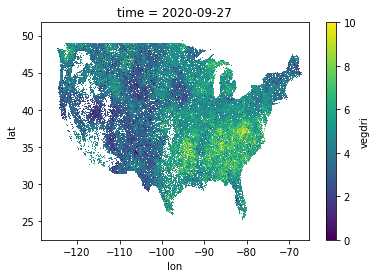

In [9]:
# now since this is lat/lon data, it will appear as nan when just glancing at the dataset view, 
# but if we plot it we can see we were successful
vegdri['vegdri'].isel(time=81).plot()

In [43]:
vegdri['vegdri'].attrs = sample['vegdri'].attrs

vegdri['vegdri']

TypeError: 'builtin_function_or_method' object is not subscriptable

<xarray.DataArray 'vegdri' (lat: 2687, lon: 5791, time: 84)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float64 51.77 51.75 51.74 51.73 ... 22.51 22.5 22.49 22.48
  * lon      (lon) float64 -128.5 -128.5 -128.5 -128.5 ... -65.42 -65.41 -65.4
  * time     (time) datetime64[ns] 2019-03-10 2019-03-17 ... 2020-10-11
Attributes:
    description:    VegDRI data provided by USGS as their web site https://ed...
    long_name:      vegdri
    standard_name:  vegdri
    units:          %
    _ChunkSizes:    [448 966]

In [36]:
vegdri.to_netcdf(f"{cwd}/vegdri.nc")

## MCDI

In [22]:
# ah ha! thanks Katherine for already compiling these wrt time
MCDI = xr.open_mfdataset([f"{dirPath}/DROUGHT_LAYERS/MCDI/SM_fraction_swe.nc", f"{dirPath}/DROUGHT_LAYERS/MCDI/SM_fraction.nc"])
MCDI

<xarray.Dataset>
Dimensions:          (time: 1521, lon: 464, lat: 200)
Coordinates:
  * time             (time) datetime64[ns] 1895-01-15 1895-02-15 ... 2021-09-15
  * lon              (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * lat              (lat) float64 49.94 49.81 49.69 49.56 ... 25.31 25.19 25.06
Data variables:
    SM_fraction      (time, lat, lon) float32 dask.array<chunksize=(1521, 200, 464), meta=np.ndarray>
    SM_fraction_swe  (time, lat, lon) float32 dask.array<chunksize=(1521, 200, 464), meta=np.ndarray>

In [37]:
MCDI.to_netcdf(f"{cwd}/mcdi.nc")

## LERI

In [5]:
leri_sample =  xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/LERI/leri_2021-10.nc")
leri_sample['leri']

<xarray.DataArray 'leri' (lat: 2844, lon: 6617)>
[18818748 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 49.54 49.53 49.52 49.51 ... 23.98 23.97 23.96 23.95
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.48 -66.47 -66.46
Attributes:
    description:    Percentiles of Landscape Evaporative Response Index (LERI...
    long_name:      leri
    standard_name:  leri
    units:          %
    _ChunkSizes:    [ 474 1103]

In [8]:
# alright, LERI is by month from 2015-01 to 2021-10
leri_dates = pd.date_range('2015-01', '2021-10', freq='MS').strftime('%Y-%m')

leri = xr.Dataset(
    coords = dict(
        lat = leri_sample['lat'].values,
        lon = leri_sample['lon'].values,
        time = leri_dates
    ),
    data_vars = dict(
        leri=(['lat','lon','time'], np.empty((len(leri_sample['lat'].values), len(leri_sample['lon'].values), len(leri_dates))) * np.nan)
    )
)
leri

<xarray.Dataset>
Dimensions:  (lat: 2844, lon: 6617, time: 82)
Coordinates:
  * lat      (lat) float64 49.54 49.53 49.52 49.51 ... 23.98 23.97 23.96 23.95
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.48 -66.47 -66.46
  * time     (time) object '2015-01' '2015-02' '2015-03' ... '2021-09' '2021-10'
Data variables:
    leri     (lat, lon, time) float64 nan nan nan nan nan ... nan nan nan nan

In [9]:
loop = tqdm(leri_dates)
for date in loop:
    loop.set_description(date)
    # using try-except in case there are holes in the data
    try:
        leri['leri'].loc[{'time':date}] = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/LERI/leri_{date}.nc")['leri'].values
    except:
        pass

  0%|          | 0/82 [00:00<?, ?it/s]

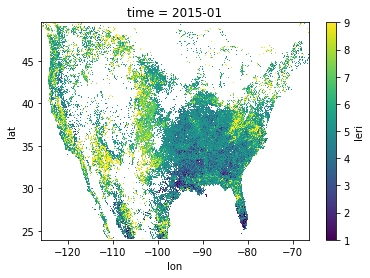

In [11]:
leri['leri'].isel(time=0).plot()

In [12]:
leri['leri'].attrs = leri_sample['leri'].attrs

In [13]:
leri.to_netcdf(f"{cwd}/leri.nc")

## GRACE

In [2]:
grace_sample = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/GRACE/GRACEsfsm_20211108.nc")
grace_sample['GRACEsfsm']

<xarray.DataArray 'GRACEsfsm' (lat: 224, lon: 464)>
[103936 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
Attributes:
    description:    Percentiles of GRACE-Based percentiles of surface soil mo...
    long_name:      GRACEsfsm
    standard_name:  GRACEsfsm
    units:          %
    _ChunkSizes:    [224 464]

It looks like there is 

- `GRACEsfsm` from 20140113 to 20211108 (weekly)
- `GRACErtzsm` from 20140113 to 20211108 (weekly)
- `GRACEgws` from 20140113 to 20211108(weekly)

In [3]:
grace_dates = pd.date_range('2014-01-13', '2021-11-08', freq='W')

empty = np.empty((len(grace_sample['lat'].values), len(grace_sample['lon'].values), len(grace_dates))) * np.nan

grace = xr.Dataset(
    coords = dict(
        lat = grace_sample['lat'].values,
        lon = grace_sample['lon'].values,
        time = grace_dates
    ),
    data_vars = dict(
        GRACEsfsm=(['lat','lon','time'], empty),
        GRACErtzsm=(['lat','lon','time'], empty),
        GRACEgws=(['lat','lon','time'], empty),
    )
)

In [6]:
loop = tqdm(grace_dates)
for date in loop:
    simp_date = date.strftime('%Y%m%d')
    loop.set_description(str(date))
    # using try-except in case there are holes in the data
    for var in ['GRACEsfsm','GRACErtzsm','GRACEgws']:
        try:
            grace[var].loc[{'time':date}] = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/GRACE/{var}_{simp_date}.nc")[var].values
        except:
            pass

  0%|          | 0/408 [00:00<?, ?it/s]

In [7]:
for var in ['GRACEsfsm','GRACErtzsm','GRACEgws']:
    grace[var].attrs = xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/GRACE/{var}_20211108.nc")[var].attrs

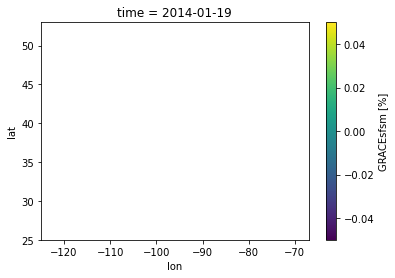

In [16]:
grace['GRACEsfsm'].isel(time=0).plot()

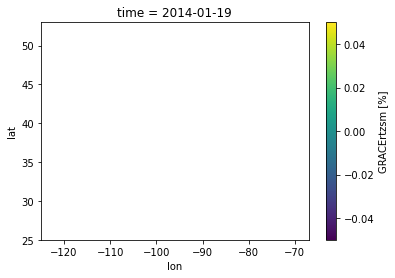

In [12]:
grace['GRACErtzsm'].isel(time=0).plot()

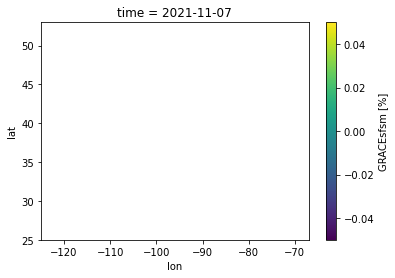

In [14]:
grace['GRACEsfsm'].isel(time=0).plot()

well that's simply not working, need to debug

## FDSI

In [18]:
# this is good to go, will just save it for local access
xr.open_dataset(f"{dirPath}/DROUGHT_LAYERS/FDSI/FDSI_CONUS_1980-2020_GRIDMET.nc").to_netcdf(f'{cwd}/fdsi.nc')

## ESI